In [2]:
from fastqaoa.indicator import get_indicator_interpolator, interpolate_diagonals
from fastqaoa import qpe_qaoa, Metrics, qaoa
from fastqaoa.ctypes.qpe_qaoa import qpe_qaoa_norm
from problems import Knapsack
import pandas as pd


import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [3]:


instances = Knapsack.get_instances()

In [4]:
df_ref = pd.read_feather("../../results/qpe_main.feather").query("qaoa == 'masked_cost'")


In [9]:
depths = [4, 8, 16]

sizes = [10]

Ms = [4, 6, 8]

shifts = np.linspace(0, 2, 20)

interpolators = {(M, s): get_indicator_interpolator(M, 4, shift=s / (1 << M)) for M in Ms for s in shifts}

data = []
for size in sizes:
    print(size, "==============")
    dfx = df_ref.query("n_qubits == @size and depth in @depths")

    for idx, dfy in dfx.groupby("problem_id"):
        print(idx)
        
        instance: Knapsack = instances[size][idx]
        f, g = instance.diagonalized()
        feas = g >= 0
        cost = instance.masked_cost()
        scale = max(abs(cost.min_val), abs(cost.max_val))

        feas = g >= 0
        
        f = f * f.n_qubits / scale
        # scaled_cost = cost * f.n_qubits / scale
        
        for (M, shift), interp in interpolators.items():
            g_new = g.scale_between_sym(M=M)
            constr = interpolate_diagonals(interp, g_new)

            for _, row in dfy.iterrows():
                sv, psucc = qpe_qaoa(f, constr=constr, betas=row.betas, gammas=row.gammas)
                # sv = qaoa(scaled_cost, betas=row.betas, gammas=row.gammas)
                
                x = Metrics.compute(sv, cost, feas).dump()
                x["shift"] = shift
                x["p_succ"] = psucc
                x["rel_approx_ratio"] = x["approx_ratio"] / row.approx_ratio
                x["rel_p_opt"] = x["p_opt"] / row.p_opt

                x["depth"] = row.depth
                x["M"] = M
                x["shift"] = shift
                x["n_qubits"] = size
                x["problem_id"] = idx
                data.append(x)


df = pd.DataFrame(data)

10 ==============
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


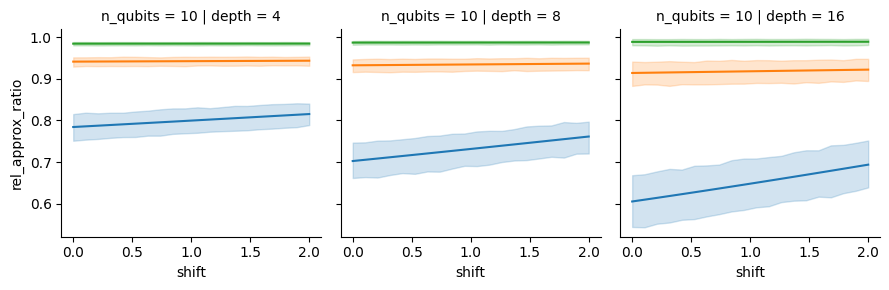

In [10]:
fg = sns.FacetGrid(df, row="n_qubits", col="depth", hue="M", palette=sns.color_palette("tab10", 3))

fg.map(sns.lineplot, "shift", "rel_approx_ratio")